<a href="https://xeek.ai/challenges/using-ai-to-validate-carbon-containment-in-the-illinois-basin/data"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Time Series Prediction for Well Injection Rates</font></h1>

<h1 align=center><font size = 4> Munish Kumar$^{1}$, Kannapan Swaminathan$^{2}$</font></h1>
<h1 align=center><font size = 4> $^{1}$Singapore University of Social Sciences, $^{2}$California Resources Corporation </font></h1>
<h1 align=center><font size = 3> April 2023 </font></h1>

Problem Statement

This challenge aims to use time series injection information and monitoring data on a carbon capture well to predict carbon capture well injection rates deltas. Correlating the change in injection rate to the behavior of other parameters in the well can be used to provide a checkpoint against carbon migration from the well or other losses during the process.  The code developed to predict injection rate deltas based on monitoring well data can be used to validate carbon containment throughout the injection of the well. 

###### References

https://www.tensorflow.org/tutorials/keras/regression

### Loading Libraries and Data

In [ ]:
#!pip install tensorflow --user
#!pip install natsort --user

In [2]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Nueral Networks are stocastic; setting random seeds ensures we get the same output each time
from numpy.random import seed
seed(1)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(2)

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print(tf.__version__)
print('Libraries imported')

2.12.0
Libraries imported


In [11]:
#Receive Data
dir_name = r'C:\Users\DELL\Documents\GitHub\munishkumar-gh.github.io\Hackathon_2023\1_RAW_Data'
filename_suffix = 'csv'

In [12]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [13]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    returnb

In [14]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [15]:
# Function to create box plot and Histogram
def creating_box_hist(column, df):
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,6),
                                        gridspec_kw={"height_ratios": (.25, .75)})    

    # assigning a graph to each ax
    sns.boxplot(df[column], ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

In [16]:
# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
fontsize = 16
alpha = 0.5
size = 18
rotation = 0

### Loading and Preprocessing Data

Load the dataset and perform some basic preprocessing steps. This includes removing any missing values, converting categorical variables into one-hot encoded format, and scaling the data using StandardScaler.    

In [17]:
base_filename = 'illinois_basing_train_04112023'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
#df.to_csv(csvs_sht, index = True, header = True)
print ("File to be loaded:", csvs_sht)

File to be loaded: C:\Users\DELL\Documents\GitHub\munishkumar-gh.github.io\Hackathon_2023\1_RAW_Data\illinois_basing_train_04112023.csv


In [18]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv(csvs_sht, thousands=',', skiprows = skiprows)
df.ends()

,SampleTimeUTC,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
0,10/1/2009 0:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
1,10/1/2009 1:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.000000
2,10/1/2009 2:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.000000
3,10/1/2009 3:00,20.543221,1.255859,52.319824,89.806754,2893.786399,116.537392,2173.734355,104.051422,1599.975952,...,120.209048,3164.138940,121.352378,3184.031604,121.476759,3216.479380,120.300598,2442.143066,111.899858,0.000000
4,10/1/2009 4:00,20.543221,1.342448,48.994263,89.610633,2893.774135,116.537714,2173.738489,104.051422,1599.975952,...,120.206798,3164.143589,121.346063,3184.019531,121.474419,3216.436283,120.307843,2442.282528,111.909219,0.000000
27393,11/18/2012 3:00,0.408333,1409.701282,95.934610,530.799145,3385.511261,129.515436,2328.919804,104.920363,NaN,...,123.910423,NaN,NaN,3323.237008,123.410697,3320.264079,122.459648,2641.522160,110.559307,-0.031250
27394,11/18/2012 4:00,0.458333,1409.036129,95.722206,531.937228,3387.451438,129.559802,2328.912415,104.911993,0.100585,...,123.913723,NaN,NaN,3323.269234,123.417552,3320.271702,122.455598,2641.527275,110.556127,-0.091320
27395,11/18/2012 5:00,0.508333,1408.648841,95.857338,526.400194,3387.077108,129.559708,2328.921606,104.916643,0.100585,...,123.916363,NaN,NaN,3323.339665,123.417567,3320.266923,122.465723,2641.525834,110.557732,-0.137501
27396,11/18/2012 6:00,0.504202,1406.788722,95.681030,532.481976,3387.618129,129.578328,2328.940994,104.911782,0.100585,...,123.926406,NaN,NaN,3323.353417,123.409700,3320.181743,122.456771,2641.547556,110.557650,0.037290
27397,11/18/2012 7:00,0.616667,1407.204333,95.600624,517.267830,3386.470343,129.565695,2328.994653,104.907342,0.100585,...,123.945400,NaN,NaN,3323.410433,123.439002,3320.304134,122.450874,2641.584741,110.556937,-0.080345


In [19]:
df1 = df.copy()

df1['SampleTimeUTC'] = pd.to_datetime(df1['SampleTimeUTC'])
df1 = df1.set_index("SampleTimeUTC")
idx = pd.date_range(df1.index[0], df1.index[-1])

#df1 = df1.reindex(idx, fill_value=np.nan).dropna()
df1.index.name = "SampleTimeUTC"

df1 = df1.asfreq('H')

#df1.index.freq = "H"
df1

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
SampleTimeUTC,,,,,,,,,,,,,,,,,,,,,
2009-10-01 00:00:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,2073.104972,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
2009-10-01 01:00:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,2073.109141,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.000000
2009-10-01 02:00:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,2073.099392,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.000000
2009-10-01 03:00:00,20.543221,1.255859,52.319824,89.806754,2893.786399,116.537392,2173.734355,104.051422,1599.975952,2073.094464,...,120.209048,3164.138940,121.352378,3184.031604,121.476759,3216.479380,120.300598,2442.143066,111.899858,0.000000
2009-10-01 04:00:00,20.543221,1.342448,48.994263,89.610633,2893.774135,116.537714,2173.738489,104.051422,1599.975952,2073.072345,...,120.206798,3164.143589,121.346063,3184.019531,121.474419,3216.436283,120.307843,2442.282528,111.909219,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-18 03:00:00,0.408333,1409.701282,95.934610,530.799145,3385.511261,129.515436,2328.919804,104.920363,NaN,2069.883183,...,123.910423,NaN,NaN,3323.237008,123.410697,3320.264079,122.459648,2641.522160,110.559307,-0.031250
2012-11-18 04:00:00,0.458333,1409.036129,95.722206,531.937228,3387.451438,129.559802,2328.912415,104.911993,0.100585,2069.890177,...,123.913723,NaN,NaN,3323.269234,123.417552,3320.271702,122.455598,2641.527275,110.556127,-0.091320
2012-11-18 05:00:00,0.508333,1408.648841,95.857338,526.400194,3387.077108,129.559708,2328.921606,104.916643,0.100585,2069.875623,...,123.916363,NaN,NaN,3323.339665,123.417567,3320.266923,122.465723,2641.525834,110.557732,-0.137501


In [20]:
df1.index

DatetimeIndex(['2009-10-01 00:00:00', '2009-10-01 01:00:00',
               '2009-10-01 02:00:00', '2009-10-01 03:00:00',
               '2009-10-01 04:00:00', '2009-10-01 05:00:00',
               '2009-10-01 06:00:00', '2009-10-01 07:00:00',
               '2009-10-01 08:00:00', '2009-10-01 09:00:00',
               ...
               '2012-11-17 22:00:00', '2012-11-17 23:00:00',
               '2012-11-18 00:00:00', '2012-11-18 01:00:00',
               '2012-11-18 02:00:00', '2012-11-18 03:00:00',
               '2012-11-18 04:00:00', '2012-11-18 05:00:00',
               '2012-11-18 06:00:00', '2012-11-18 07:00:00'],
              dtype='datetime64[ns]', name='SampleTimeUTC', length=27464, freq='H')

In [22]:
# in pandas axis=0 represents rows (default) and axis=1 represents columns.
#df1.drop(['Avg_PLT_CO2InjRate_TPH'], axis=1, inplace=True)
df1.ends()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
SampleTimeUTC,,,,,,,,,,,,,,,,,,,,,
2009-10-01 00:00:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,2073.104972,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
2009-10-01 01:00:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,2073.109141,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.000000
2009-10-01 02:00:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,2073.099392,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.000000
2009-10-01 03:00:00,20.543221,1.255859,52.319824,89.806754,2893.786399,116.537392,2173.734355,104.051422,1599.975952,2073.094464,...,120.209048,3164.138940,121.352378,3184.031604,121.476759,3216.479380,120.300598,2442.143066,111.899858,0.000000
2009-10-01 04:00:00,20.543221,1.342448,48.994263,89.610633,2893.774135,116.537714,2173.738489,104.051422,1599.975952,2073.072345,...,120.206798,3164.143589,121.346063,3184.019531,121.474419,3216.436283,120.307843,2442.282528,111.909219,0.000000
2012-11-18 03:00:00,0.408333,1409.701282,95.934610,530.799145,3385.511261,129.515436,2328.919804,104.920363,NaN,2069.883183,...,123.910423,NaN,NaN,3323.237008,123.410697,3320.264079,122.459648,2641.522160,110.559307,-0.031250
2012-11-18 04:00:00,0.458333,1409.036129,95.722206,531.937228,3387.451438,129.559802,2328.912415,104.911993,0.100585,2069.890177,...,123.913723,NaN,NaN,3323.269234,123.417552,3320.271702,122.455598,2641.527275,110.556127,-0.091320
2012-11-18 05:00:00,0.508333,1408.648841,95.857338,526.400194,3387.077108,129.559708,2328.921606,104.916643,0.100585,2069.875623,...,123.916363,NaN,NaN,3323.339665,123.417567,3320.266923,122.465723,2641.525834,110.557732,-0.137501
2012-11-18 06:00:00,0.504202,1406.788722,95.681030,532.481976,3387.618129,129.578328,2328.940994,104.911782,0.100585,2069.930707,...,123.926406,NaN,NaN,3323.353417,123.409700,3320.181743,122.456771,2641.547556,110.557650,0.037290


In [23]:
# Check for Missing Values

print("Column Names: ", df1.columns.values)
print("\n")
print("Information:", df1.info())
print("\n")
print("Descriptive Statistics: ")
df1.describe()

Column Names:  ['Avg_PLT_CO2VentRate_TPH' 'Avg_CCS1_WHCO2InjPs_psi'
 'Avg_CCS1_WHCO2InjTp_F' 'Avg_CCS1_ANPs_psi' 'Avg_CCS1_DH6325Ps_psi'
 'Avg_CCS1_DH6325Tp_F' 'Avg_VW1_WBTbgPs_psi' 'Avg_VW1_WBTbgTp_F'
 'Avg_VW1_ANPs_psi' 'Avg_VW1_Z11D4917Ps_psi' 'Avg_VW1_Z11D4917Tp_F'
 'Avg_VW1_Z10D5001Ps_psi' 'Avg_VW1_Z10D5001Tp_F' 'Avg_VW1_Z09D5653Ps_psi'
 'Avg_VW1_Z09D5653Tp_F' 'Avg_VW1_Z08D5840Ps_psi' 'Avg_VW1_Z08D5840Tp_F'
 'Avg_VW1_Z07D6416Ps_psi' 'Avg_VW1_Z07D6416Tp_F' 'Avg_VW1_Z06D6632Ps_psi'
 'Avg_VW1_Z06D6632Tp_F' 'Avg_VW1_Z05D6720Ps_psi' 'Avg_VW1_Z05D6720Tp_F'
 'Avg_VW1_Z04D6837Ps_psi' 'Avg_VW1_Z04D6837Tp_F' 'Avg_VW1_Z03D6945Ps_psi'
 'Avg_VW1_Z03D6945Tp_F' 'Avg_VW1_Z02D6982Ps_psi' 'Avg_VW1_Z02D6982Tp_F'
 'Avg_VW1_Z01D7061Ps_psi' 'Avg_VW1_Z01D7061Tp_F'
 'Avg_VW1_Z0910D5482Ps_psi' 'Avg_VW1_Z0910D5482Tp_F' 'inj_diff\xa0']


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27464 entries, 2009-10-01 00:00:00 to 2012-11-18 07:00:00
Freq: H
Data columns (total 34 columns):
 #   Column         

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
count,27398.000000,27270.000000,27398.000000,27304.000000,27398.000000,27398.000000,26127.000000,26061.000000,23487.000000,26688.000000,...,26600.000000,24361.000000,25932.000000,26423.000000,26423.000000,25307.000000,25108.000000,26709.000000,26709.000000,27397.000000
mean,2.122022,1239.861825,89.766221,560.862134,3244.168246,127.738740,1801.844864,80.794406,525.000311,1597.476442,...,90.967574,2350.941782,182.281703,2456.608853,91.272574,2300.195377,85.859433,1855.603011,86.313992,0.001651
std,133.162146,817.740091,48.287324,445.931405,173.471253,7.167508,999.374082,44.286916,3988.707539,873.254402,...,51.589928,1495.701897,368.506491,1459.143450,52.699934,1521.416947,55.366988,1017.588588,46.720937,82.690245
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11021.132640
25%,0.000000,1235.469308,92.953925,523.536663,3233.023426,127.166621,2173.526853,103.423346,0.452148,2070.333608,...,118.813235,0.000000,0.000000,0.000000,32.002941,0.000000,0.000000,2353.328436,110.492078,-0.072917
50%,0.058333,1338.872024,96.268226,564.901591,3286.067870,130.109008,2322.382139,104.196940,4.656250,2073.364497,...,119.543503,3299.938442,121.297661,3316.204091,121.263339,3318.194554,121.362099,2374.948004,111.453740,0.000000
75%,0.150000,1361.045834,96.851236,604.763645,3324.735273,131.082033,2379.839354,105.044018,16.900514,2074.094025,...,119.852003,3320.609979,122.832244,3332.014610,122.027798,3327.320356,122.551008,2416.106108,111.976222,0.074305
max,18333.150000,39032.410160,2879.416016,24105.630860,3515.880615,135.670399,4954.731745,120.056561,31993.509770,2377.999424,...,125.766369,3457.878882,1602.857486,3499.615312,124.310501,3445.065566,133.912303,2758.334188,113.687965,7033.459028


In [24]:
print("Name of Columns that have Missing Values:\n", df1.columns[df1.isnull().any()])

Name of Columns that have Missing Values:
 Index(['Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi',
       'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi',
       'Avg_CCS1_DH6325Tp_F', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F',
       'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F',
       'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F',
       'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F',
       'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F',
       'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F',
       'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F',
       'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F',
       'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F',
       'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F',
       'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F',
       'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F',
       'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F', 'inj_diff '],
      dtype='object')


In [25]:
df2 = df1.ffill(axis = 0) #Forward fill null or blank values
df3 = df2.backfill(axis = 0) #Back fill null or blank values

In [26]:
df3.isnull().sum()

Avg_PLT_CO2VentRate_TPH     0
Avg_CCS1_WHCO2InjPs_psi     0
Avg_CCS1_WHCO2InjTp_F       0
Avg_CCS1_ANPs_psi           0
Avg_CCS1_DH6325Ps_psi       0
Avg_CCS1_DH6325Tp_F         0
Avg_VW1_WBTbgPs_psi         0
Avg_VW1_WBTbgTp_F           0
Avg_VW1_ANPs_psi            0
Avg_VW1_Z11D4917Ps_psi      0
Avg_VW1_Z11D4917Tp_F        0
Avg_VW1_Z10D5001Ps_psi      0
Avg_VW1_Z10D5001Tp_F        0
Avg_VW1_Z09D5653Ps_psi      0
Avg_VW1_Z09D5653Tp_F        0
Avg_VW1_Z08D5840Ps_psi      0
Avg_VW1_Z08D5840Tp_F        0
Avg_VW1_Z07D6416Ps_psi      0
Avg_VW1_Z07D6416Tp_F        0
Avg_VW1_Z06D6632Ps_psi      0
Avg_VW1_Z06D6632Tp_F        0
Avg_VW1_Z05D6720Ps_psi      0
Avg_VW1_Z05D6720Tp_F        0
Avg_VW1_Z04D6837Ps_psi      0
Avg_VW1_Z04D6837Tp_F        0
Avg_VW1_Z03D6945Ps_psi      0
Avg_VW1_Z03D6945Tp_F        0
Avg_VW1_Z02D6982Ps_psi      0
Avg_VW1_Z02D6982Tp_F        0
Avg_VW1_Z01D7061Ps_psi      0
Avg_VW1_Z01D7061Tp_F        0
Avg_VW1_Z0910D5482Ps_psi    0
Avg_VW1_Z0910D5482Tp_F      0
inj_diff  

In [27]:
base_filename = 'Cleaned_data'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
df3.to_csv(csvs_sht, index = True, header = True)
print ("File exported:", base_filename + "." + filename_suffix)

File exported: Cleaned_data.csv


### Exploratory Data Analysis

Viewing the data to make sense of trends

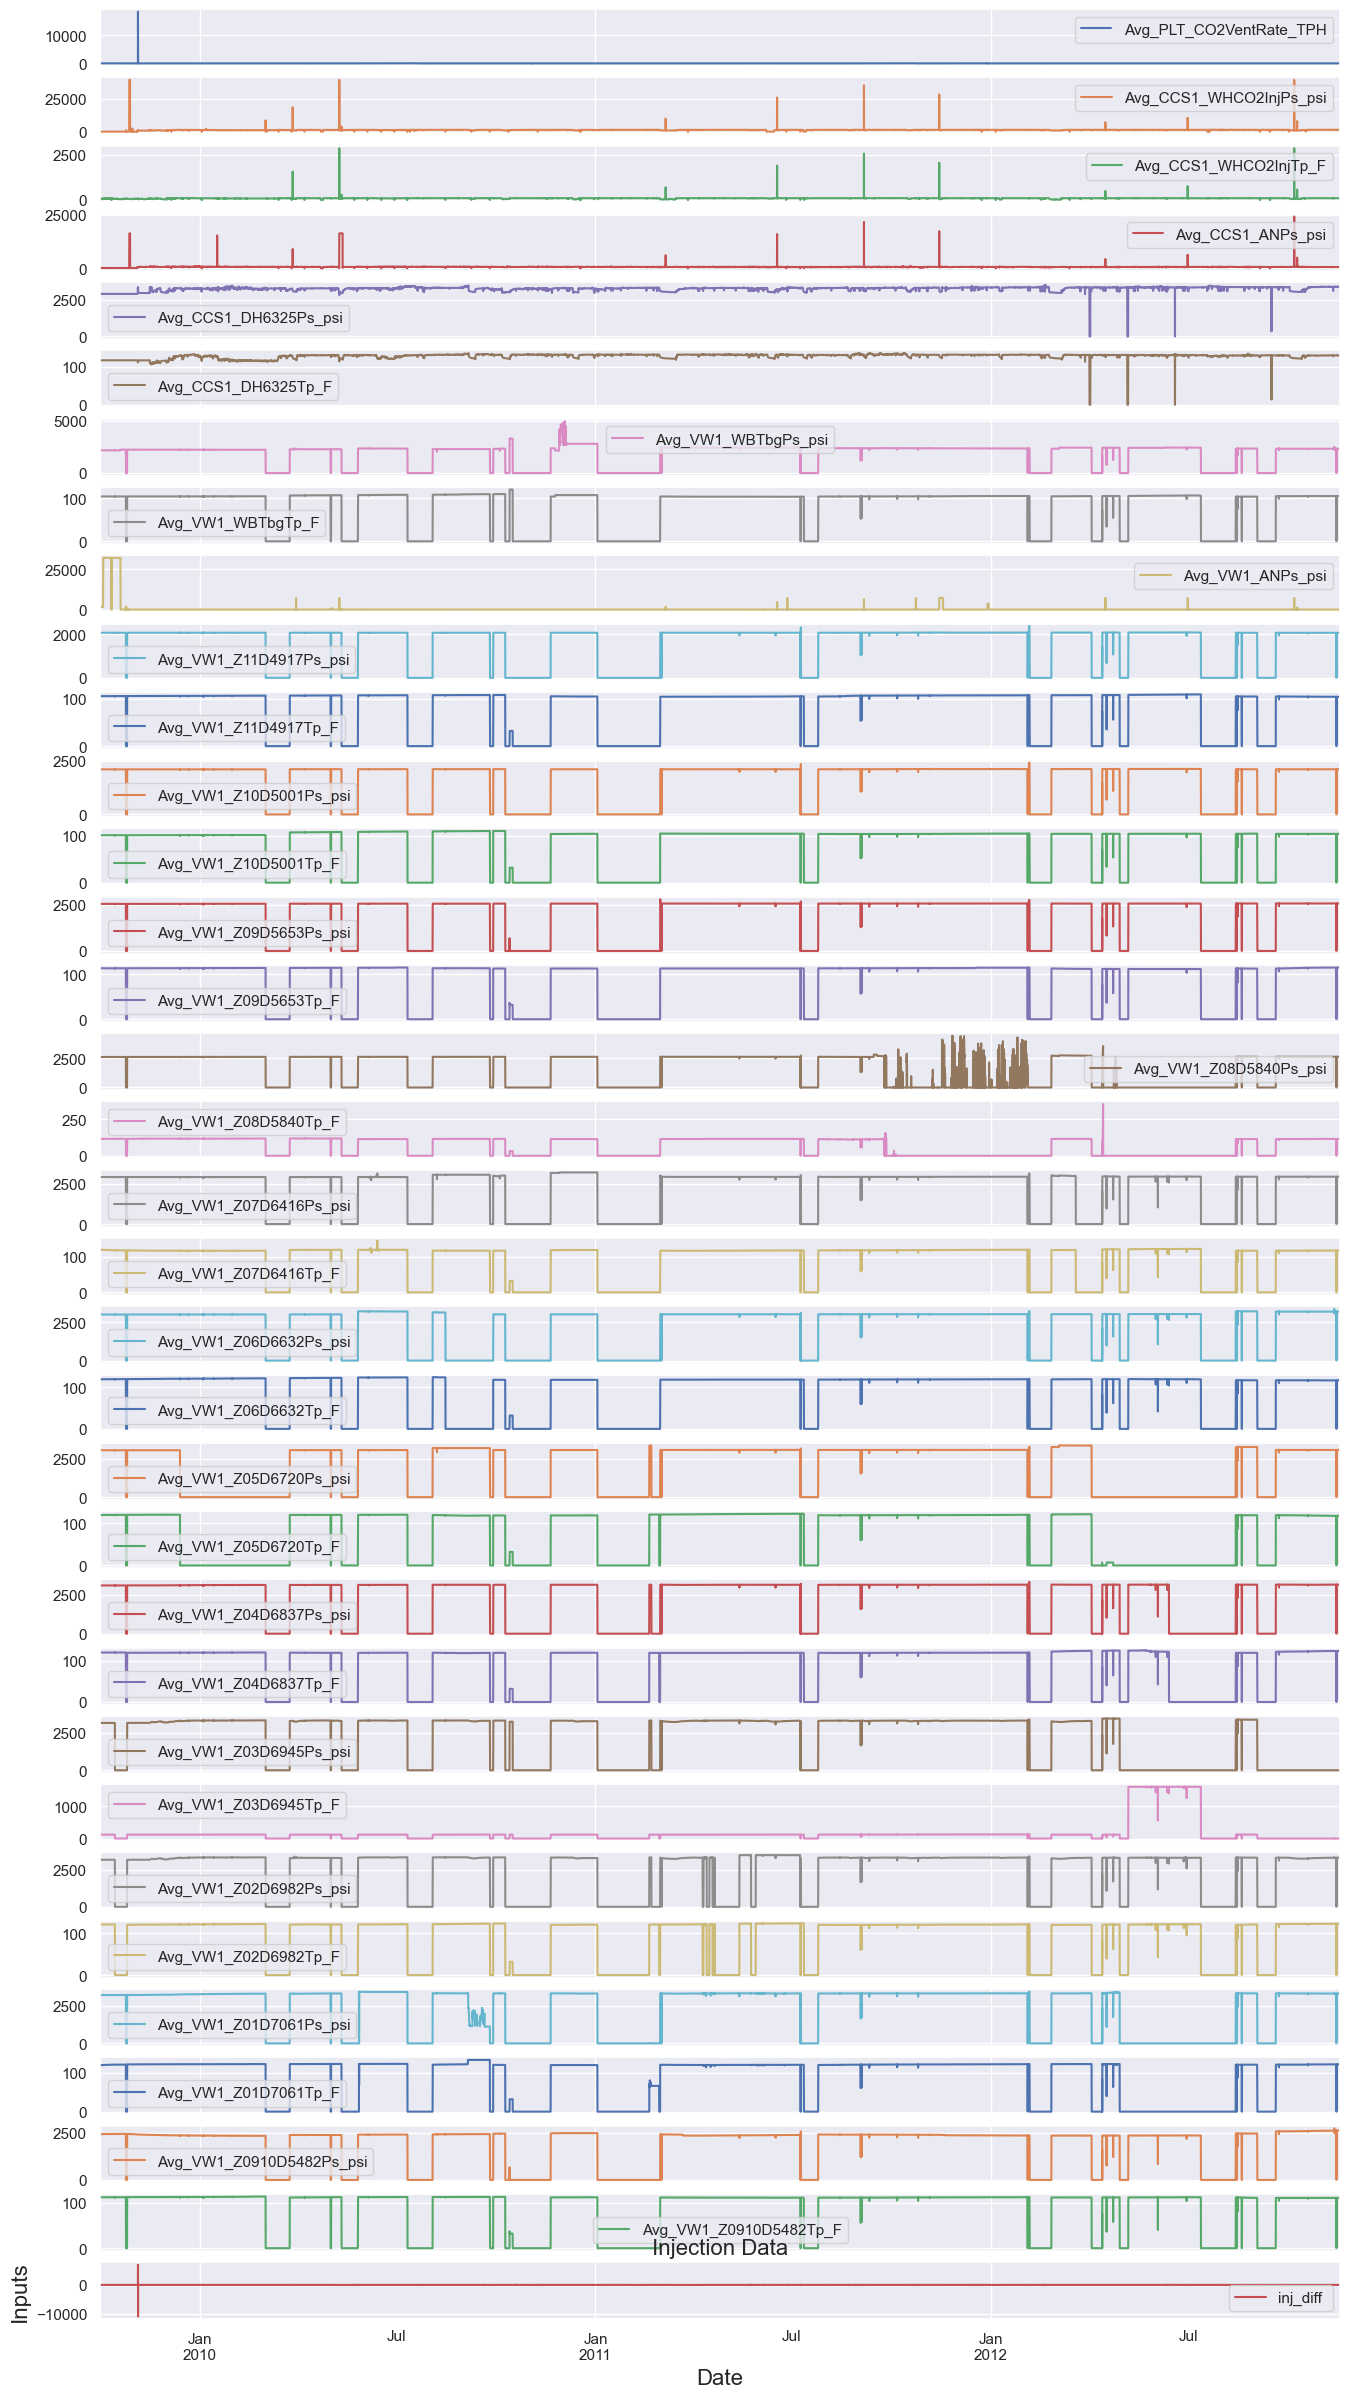

In [28]:
# sort by date
df3 = df3.sort_index()

# plot
df3.plot(figsize=(16, 30), subplots=True, sharex=True)
plt.title("Injection Data", size=fontsize)
plt.xlabel("Date", size=fontsize)
plt.ylabel("Inputs", size=fontsize)
plt.show()

In [29]:
df3.corr().style.background_gradient(cmap = "YlGnBu")

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,Avg_VW1_Z11D4917Tp_F,Avg_VW1_Z10D5001Ps_psi,Avg_VW1_Z10D5001Tp_F,Avg_VW1_Z09D5653Ps_psi,Avg_VW1_Z09D5653Tp_F,Avg_VW1_Z08D5840Ps_psi,Avg_VW1_Z08D5840Tp_F,Avg_VW1_Z07D6416Ps_psi,Avg_VW1_Z07D6416Tp_F,Avg_VW1_Z06D6632Ps_psi,Avg_VW1_Z06D6632Tp_F,Avg_VW1_Z05D6720Ps_psi,Avg_VW1_Z05D6720Tp_F,Avg_VW1_Z04D6837Ps_psi,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
Avg_PLT_CO2VentRate_TPH,1.000000,-0.001364,-0.004955,-0.001381,-0.005509,-0.022164,0.005692,0.007135,0.016188,0.007093,0.006990,0.007022,0.006281,0.006972,0.007194,0.010122,0.010824,0.007066,0.007345,0.007633,0.008106,0.010311,0.010627,0.007411,0.007463,0.005861,-0.002969,0.003924,0.004620,0.008151,0.008511,0.007345,0.007255,0.528037
Avg_CCS1_WHCO2InjPs_psi,-0.001364,1.000000,0.527558,0.531192,0.063780,0.068782,-0.000876,-0.004762,-0.100438,-0.003672,-0.004546,-0.003519,-0.003741,-0.003485,-0.005130,-0.025238,-0.029551,-0.005234,-0.006373,-0.004003,-0.006988,-0.004369,-0.005453,-0.008218,-0.008810,-0.004897,0.019764,0.013153,0.012658,-0.011794,-0.014192,-0.002877,-0.005448,0.000667
Avg_CCS1_WHCO2InjTp_F,-0.004955,0.527558,1.000000,0.339498,0.140601,0.140344,-0.024939,-0.030249,-0.029594,-0.030543,-0.030845,-0.030250,-0.028387,-0.030164,-0.031682,-0.055183,-0.060487,-0.031704,-0.031581,-0.033789,-0.037450,-0.033965,-0.033922,-0.037522,-0.037766,-0.039884,0.027791,-0.018309,-0.021096,-0.043363,-0.045724,-0.030112,-0.032416,0.000158
Avg_CCS1_ANPs_psi,-0.001381,0.531192,0.339498,1.000000,-0.066233,-0.038601,-0.007787,-0.004489,-0.048813,-0.004923,-0.005102,-0.004855,-0.003213,-0.004921,-0.004881,0.011621,0.013935,-0.002945,-0.002757,-0.004298,-0.002994,0.002915,0.001975,-0.003321,-0.005789,0.009734,-0.011867,0.009021,0.007837,0.002869,0.001407,-0.004882,-0.005299,-0.000036
Avg_CCS1_DH6325Ps_psi,-0.005509,0.063780,0.140601,-0.066233,1.000000,0.820485,-0.050103,-0.059286,-0.243123,-0.055646,-0.055436,-0.054994,-0.051434,-0.054823,-0.057385,-0.160931,-0.177985,-0.033067,-0.032410,-0.055187,-0.063403,-0.116406,-0.116821,-0.072602,-0.072154,-0.084053,0.101697,-0.016125,-0.021077,-0.097669,-0.109175,-0.057149,-0.058973,0.005210
Avg_CCS1_DH6325Tp_F,-0.022164,0.068782,0.140344,-0.038601,0.820485,1.000000,-0.034918,-0.060577,-0.185115,-0.064697,-0.062923,-0.063481,-0.051553,-0.063255,-0.065352,-0.175207,-0.195445,-0.036020,-0.037113,-0.090610,-0.097003,0.033398,0.039221,-0.071353,-0.068459,-0.051409,0.060483,-0.050955,-0.051949,-0.092949,-0.091320,-0.063363,-0.067591,-0.000507
Avg_VW1_WBTbgPs_psi,0.005692,-0.000876,-0.024939,-0.007787,-0.050103,-0.034918,1.000000,0.980769,0.045447,0.975284,0.971993,0.975351,0.972043,0.975518,0.971670,0.650443,0.617620,0.942768,0.936988,0.891747,0.887245,0.700420,0.674754,0.901847,0.878957,0.734334,0.269035,0.878830,0.854690,0.821000,0.813801,0.974732,0.972005,0.000071
Avg_VW1_WBTbgTp_F,0.007135,-0.004762,-0.030249,-0.004489,-0.059286,-0.060577,0.980769,1.000000,0.065583,0.983095,0.994692,0.983136,0.994691,0.983116,0.994323,0.662430,0.642785,0.949368,0.959886,0.886783,0.896374,0.695267,0.681319,0.911063,0.901719,0.734893,0.262664,0.888731,0.879212,0.828227,0.839624,0.981957,0.994449,-0.000024
Avg_VW1_ANPs_psi,0.016188,-0.100438,-0.029594,-0.048813,-0.243123,-0.185115,0.045447,0.065583,1.000000,0.069409,0.067283,0.068744,0.060073,0.068191,0.068966,0.091952,0.093281,0.069020,0.072667,0.072507,0.075678,0.093017,0.094674,0.070443,0.071706,0.002744,-0.030826,-0.018469,-0.014386,0.075530,0.077580,0.073481,0.069634,-0.000036
Avg_VW1_Z11D4917Ps_psi,0.007093,-0.003672,-0.030543,-0.004923,-0.055646,-0.064697,0.975284,0.983095,0.069409,1.000000,0.991631,0.999996,0.990645,0.999967,0.991690,0.670970,0.63380

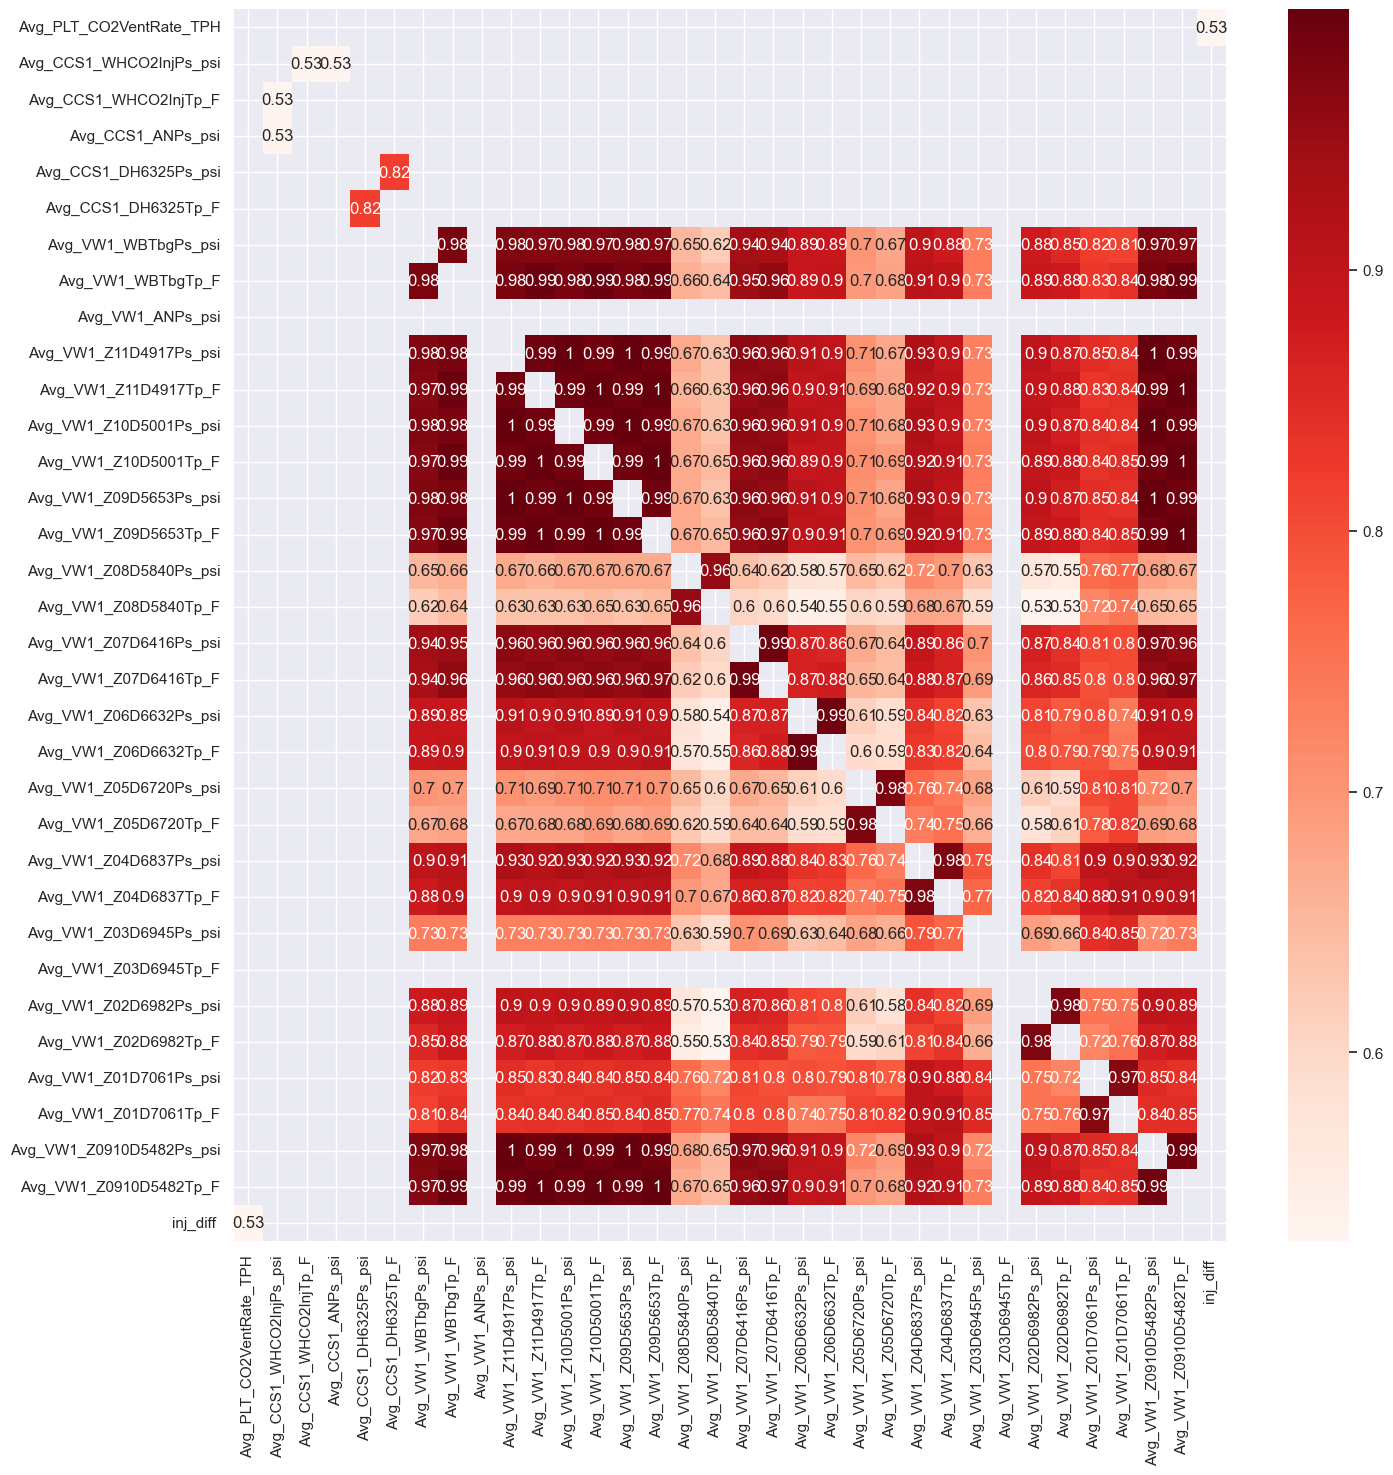

In [30]:
cor_matrix = df3.corr()

filteredDf = cor_matrix[((cor_matrix >= .5) | (cor_matrix <= -.5)) & (cor_matrix !=1.000)]
plt.figure(figsize=(16,16))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.savefig('matrix.jpeg')
plt.show()

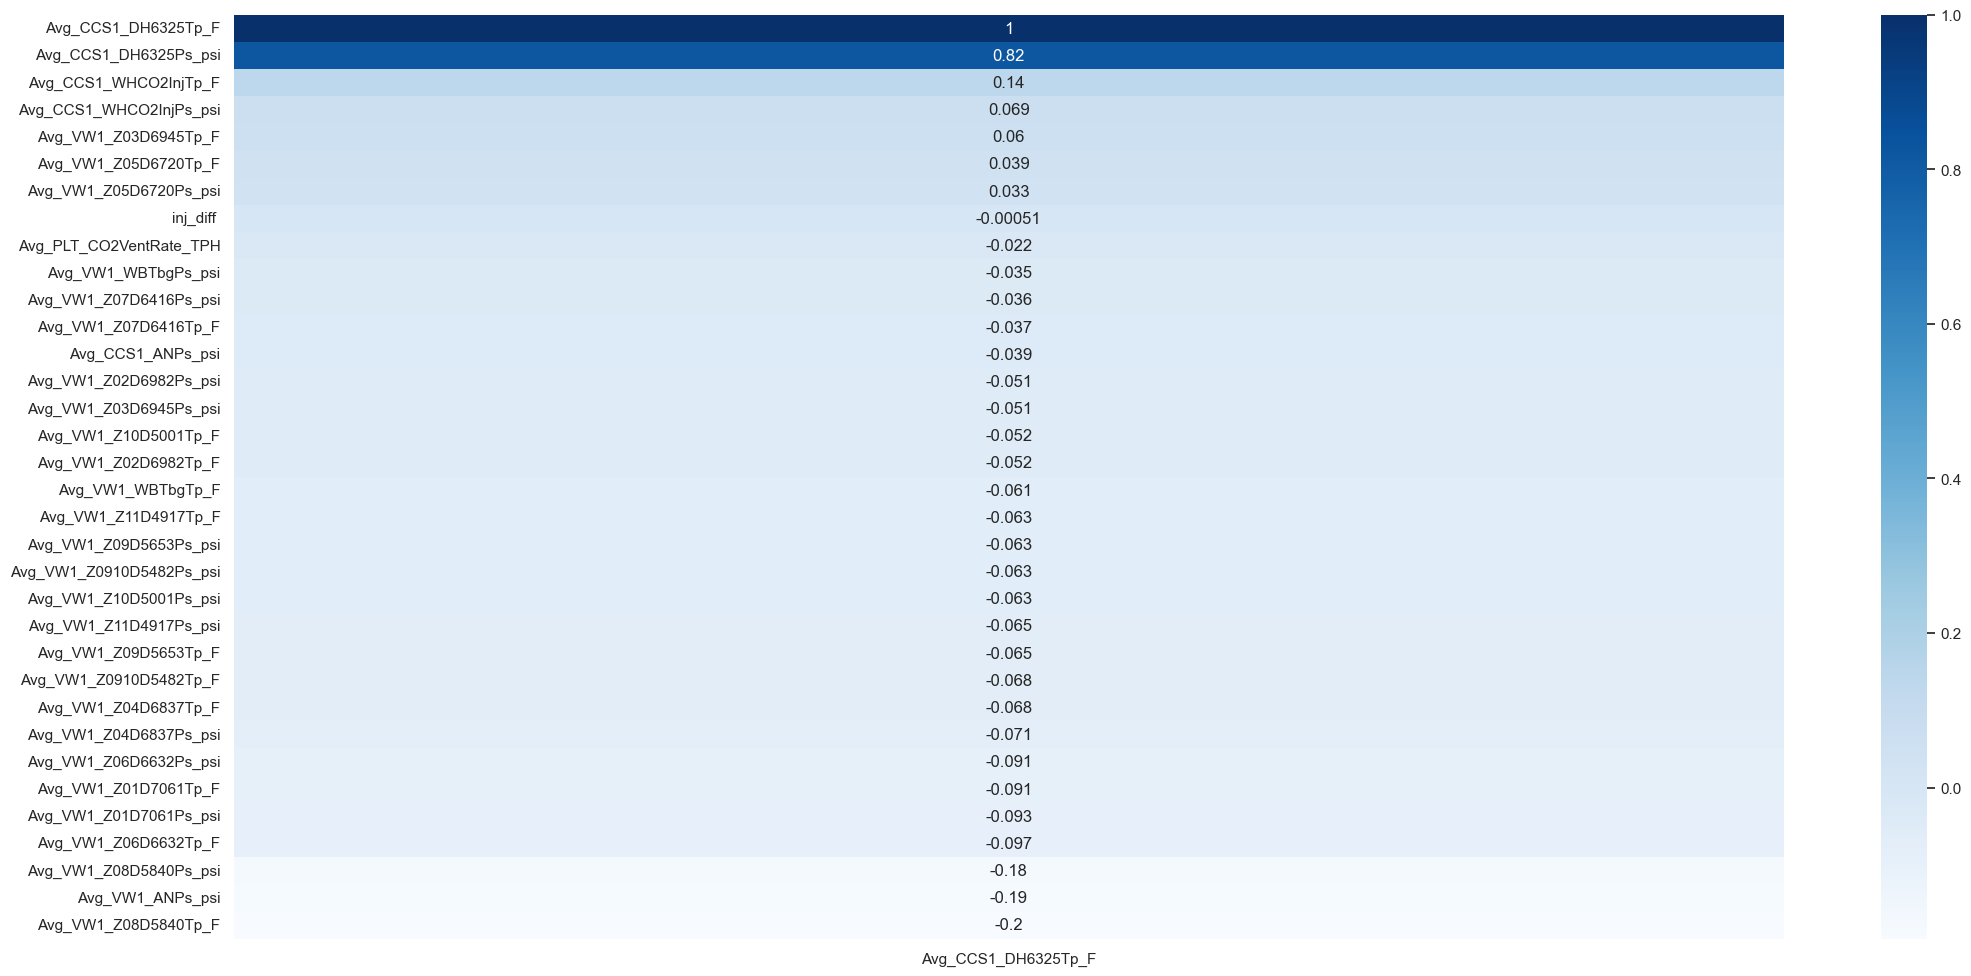

In [31]:
#Ranking the correlatable variables
cor_matrix = df3.corr()
cor_matrix[['Avg_CCS1_DH6325Tp_F']]

f, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(cor_matrix[['Avg_CCS1_DH6325Tp_F']].sort_values(by=['Avg_CCS1_DH6325Tp_F'], 
                                                 ascending =False), annot=True, cmap="Blues")

plt.show()

In [ ]:
for i in df3.columns:
    creating_box_hist(str(i), df3)

Feature Selection

Use correlation analysis to identify the most important features for the machine learning model. This will help to improve the accuracy of predictions and reduce the risk of overfitting

In [ ]:
# Compute correlation matrix
corr_matrix = data.corr()

# Generate heatmap of correlation matrix
import seaborn as sns
sns.heatmap(corr_matrix)
plt.show()

# Select the most correlated features
corr_threshold = 0.5
corr_pairs = np.where(np.abs(corr_matrix) > corr_threshold)
corr_pairs = [(corr_matrix.iloc[i, j], i, j) for i, j in zip(*corr_pairs) if i != j and i < j]
corr_pairs.sort(reverse=True)


Model Development

Split the data using the preprocessed data. Split the dataset into training and testing sets. This will allow to evaluate the performance of the machine learning model on unseen data.

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data['target'], test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Selection and Tuning

Experiment different machine learning algorithms, such as logistic regression, decision trees, and random forests, and tune the hyperparameters of each model to find the best combination for the task at hand.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

# Define hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'saga']}

# Define grid search
grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search
grid.fit(X_train_scaled, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# Retrain the model with best hyperparameters
model_tuned = LogisticRegression(C=10, penalty='l2', solver='liblinear')
model_tuned.fit(X_train_scaled, y_train)

# Make predictions on testing set
y_pred_tuned = logreg_tuned.predict(X_test_scaled)

# Calculate accuracy
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Tuned Accuracy:", accuracy_tuned)


# Conclusion

In [ ]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Submission

Once the machine learning model is developed and evaluated, contestants submit the ML code to an SPEMLChallenge@gmail.com.  The results are submitted to the XEEK.org platform for preliminary scoring.   